# Method to calculate the parameters of the energy signature model. Implementation using simulation data


### Import data and rearrange

In [1]:
# Library and data import
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Results path and data import
path_results = ('data/Input_HDU.txt')
energy_df = pd.read_csv(path_results, sep='\t', decimal = '.', skiprows=1)

# Rename columns with conflictive characters
energy_df.rename(columns = {energy_df.columns[1]:'T_Aussen',
                            energy_df.columns[2]:'Q_Lueftung',
                            energy_df.columns[3]:'Q_Heizen_Kuehlen'}, 
                inplace = True)

#Eliminate "double" and "NaN" columns
energy_df = energy_df.drop(columns=['Unnamed: 11', 'double'])

# Set datetime index
energy_df.index = pd.date_range(start='2022-01-01 00:00', periods=8761, freq='H')

# Take out the last hour
energy_df = energy_df.iloc[:-1,:]

#HDU area
hdu_area = 54
# Array of colors according to RoofKIT color code
colarray = ['#89989A', '#C37246', '#4A5F31', '#4653A5', '#E2B01F', '#000000']


In [2]:
# See dataframe structure
energy_df.head()

,T_Aussen,Q_Lueftung,Q_Heizen_Kuehlen,Raumtemperatur,Te_gl.Mittel,Q_el_need,CO2-Konzentration,Raumfeuchte,Stromverb,TWW-Verb
2022-01-01 00:00:00,1.9,-1.70,3.47,20.06,-2.98,3.96,1200.82,51.78,158.51,0.0
2022-01-01 01:00:00,4.3,-1.48,4.97,19.99,-2.98,3.96,1207.32,51.92,117.04,0.0
2022-01-01 02:00:00,6.0,-1.32,5.87,19.94,-2.98,4.03,1211.90,52.03,105.37,0.0
2022-01-01 03:00:00,6.8,-1.25,6.56,19.91,-2.98,4.21,1215.13,52.14,102.58,0.0
2022-01-01 04:00:00,7.0,-1.23,7.03,19.88,-2.98,4.61,1217.41,52.23,104.84,0.0


### Scatter plots to evaluate the data at first sight

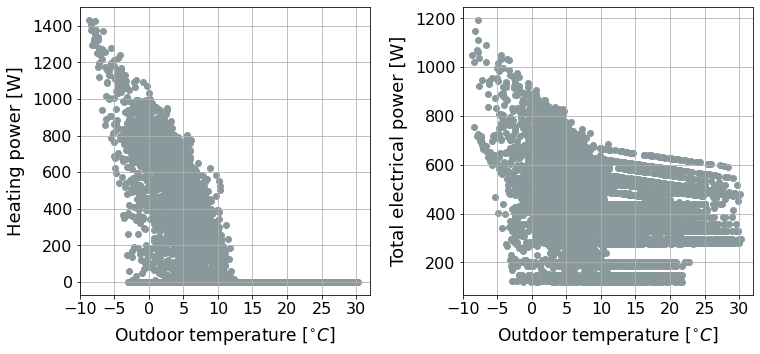

In [3]:
# Scatter plots - heat and power against outdoor temperature
fig, ax = plt.subplots(1,2,figsize=[11,5],
                       facecolor='w', 
                       edgecolor='w')
plt.subplots_adjust(bottom = 0.17, top = 0.97,
                    left = 0.11, right = 0.96,
                    wspace = 0.32) 
ax[0].scatter(energy_df.T_Aussen, energy_df.Q_Heizen_Kuehlen*hdu_area, 
              marker = 'o', c=colarray[0])
ax[1].scatter(energy_df.T_Aussen, energy_df.Q_el_need*hdu_area, 
              marker = 'o', c=colarray[0])

ax[0].set_ylabel('Heating power [W]', fontsize=18, labelpad=7)
ax[1].set_ylabel('Total electrical power [W]', fontsize=18, labelpad=7)
ax[0].xaxis.set_ticks(np.arange(-10,31,5))
ax[1].xaxis.set_ticks(np.arange(-10,31,5))
ax[0].set_xlabel('Outdoor temperature [$^{\circ}C$]', fontsize=17, labelpad = 8)
ax[1].set_xlabel('Outdoor temperature [$^{\circ}C$]', fontsize=17, labelpad = 8)
ax[0].set_xlim([-10,32])
ax[1].set_xlim([-10,32])
for k in range(2):
    ax[k].tick_params(labelsize = 16)
    # ax[k].xaxis.set_tick_params(rotation=45)
    ax[k].grid(True)

### Data cleaning procedure

- Determine the base load. The hourly base load profile is obtained by selecting the minimum value of the total electrical energy in every hour. 
- Subtract the base load to the total electrical energy to obtain the heat pump consumption. 
- Plot again the resulting profile for the heat pump electrical energy.

In [24]:
# Collect the minimum registered value for every hour
# Electrical base load profile is built then with the 24-hour minimum values
base_load_list = list()
for h in range(24):
    base_load_list.append(energy_df.Q_el_need[energy_df.Q_el_need.index.hour == h].min()) 

base_load = pd.DataFrame(base_load_list*365)
base_load.index = energy_df.Q_el_need.index
energy_df['Q_hp'] = energy_df.Q_el_need - base_load[0]

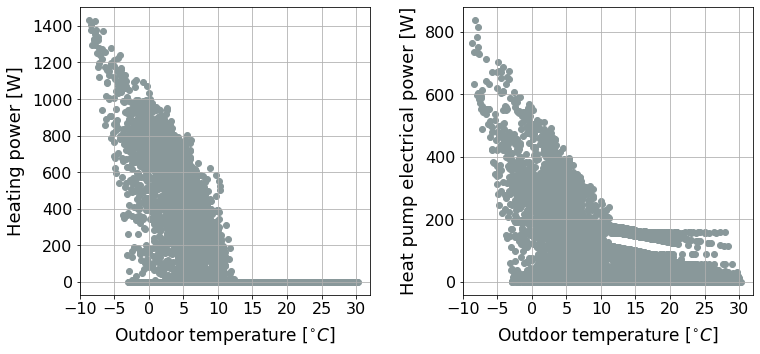

In [25]:
# Scatter plots - heat and heat pump power against outdoor temperature
fig, ax = plt.subplots(1,2,figsize=[11,5],
                       facecolor='w', 
                       edgecolor='w')
plt.subplots_adjust(bottom = 0.17, top = 0.97,
                    left = 0.11, right = 0.96,
                    wspace = 0.32) 
ax[0].scatter(energy_df.T_Aussen, energy_df.Q_Heizen_Kuehlen*hdu_area, 
              marker = 'o', c=colarray[0])
ax[1].scatter(energy_df.T_Aussen, energy_df.Q_hp*hdu_area, 
              marker = 'o', c=colarray[0])

ax[0].set_ylabel('Heating power [W]', fontsize=18, labelpad=7)
ax[1].set_ylabel('Heat pump electrical power [W]', fontsize=18, labelpad=7)
ax[0].xaxis.set_ticks(np.arange(-10,31,5))
ax[1].xaxis.set_ticks(np.arange(-10,31,5))
ax[0].set_xlabel('Outdoor temperature [$^{\circ}C$]', fontsize=17, labelpad = 8)
ax[1].set_xlabel('Outdoor temperature [$^{\circ}C$]', fontsize=17, labelpad = 8)
ax[0].set_xlim([-10,32])
ax[1].set_xlim([-10,32])
for k in range(2):
    ax[k].tick_params(labelsize = 16)
    # ax[k].xaxis.set_tick_params(rotation=45)
    ax[k].grid(True)

# Energy signature

#### Energy balance equation

$Q_{hp} = Qtot*(Tb - Tout) + Pdhw + Pdhw_c$

### Apply energy signature algorithm

The required variables (heat pump power, room and outdoor temperatures) are obtained from the main dataframe. 

The internal heat gains ($I_{hg}$) for the building must be estimated. Usually, this is done using constant values (i.e. 3 $W/m^2$). In this case, this value is estimated using the energy consmption in winter at night, were no heating and hot water is consumed. Therefore, the mean value of the total power at night (between 0 and 5 AM) is used as a constant. 

Besides, the starting balance temperature must be defined ($Tb$ = 14°C). 


In [26]:
# Variable initialization
Tb_i = 14
print('Initial balance temperature = ',Tb_i)

Q_hp = energy_df.Q_hp*hdu_area
Tout = energy_df.T_Aussen
Troom = energy_df.Raumtemperatur

# Estimate internal heat gains
Ihg_wint = energy_df.Stromverb[(energy_df.Stromverb.index >= '2022-12-01') | (energy_df.Stromverb.index < '2022-03-01')]
Ihg = Ihg_wint[Ihg_wint.index.hour < 5].mean()
print('Internal heat gains = ',Ihg)

Initial balance temperature =  14
Internal heat gains =  121.18955555555584


Estimate $Pdhw$ and $Pdhw_c$

- $Pdhw_c$ is the mean heat pump energy value on the day of the minimum average consumption, when the outdoor temperature is above the balance temperature
- $Pdhw$ is the mean value of all heat pump energy values,nwhen the outdoor temperature is above the balance temperature

In [27]:
#Calculate Pdhwc
Pdhw_c = Q_hp[Tout>Tb_i].resample('D').min().dropna().mean()
print('Base domestic hot water losses = ',Pdhw_c)
# Calculate Pdhw
Pdhw = Q_hp[Tout>Tb_i].mean()
print('Domestic hot water consumption = ',Pdhw)

Base domestic hot water losses =  0.05043956043956042
Domestic hot water consumption =  29.275700998966443


Estimate $Qtot$ - according to the following equation:

$Qtot = \dfrac{(Q_{hp} - Pdhw - Pdhw_c + I_{hg})}{\overline{Troom} - \overline{Tout}}$


In [28]:
#Calculate Qtot
Q_hp_wint = Q_hp[(Q_hp.index >= '2022-12-01') | (Q_hp.index < '2022-03-01')]
Php_sup = Q_hp_wint[Q_hp_wint.index.hour < 5].mean()
Qtot = (Php_sup - Pdhw - Pdhw_c + Ihg)/(Troom.mean() - Tout.mean())
print('Heat loss coefficient - Qtot = ',Qtot)

Heat loss coefficient - Qtot =  28.41626183200702


### Create optimization function to calculate Tb iteratively

Optimize by minimizing the root mean squared error (RMSE)

Piecewise prediction of the heat pump power depending on the balance temperature $Tb$

In [29]:
# Define RMSE over energy balance function
def energy_balance_RMSE(Tb_i):
    y_pred = Qtot*(Tb_i - Tout)*(Tb_i > Tout)  + np.ones_like(Tout)*(Pdhw + Pdhw_c)
    y_act = Q_hp
    rmse =  (((y_pred-y_act)**(2)).mean())**(1/2)
    return rmse

Use a scalar optimization, in this case $Tb$ is bounded between 5 and 15°C

In [30]:
from scipy.optimize import minimize_scalar
res = minimize_scalar(energy_balance_RMSE, bounds=(5, 15), method='bounded')
Tb = res.x
print('Balance temperature - Tb = ',Tb)

Balance temperature - Tb =  8.686970138796518


## Estimate the energy signature function through linear regression

The calculated Tb is used as break point for the piecewise function

In [31]:
# Estimate coefficients linear function and base load
coef_lin = np.polyfit(Tout[Tb >= Tout],  Q_hp[Tb >= Tout], deg=1)
coef_const = np.polyfit(Tout[Tb <= Tout],  Q_hp[Tb <= Tout], deg=0)

### Plot the resulting function

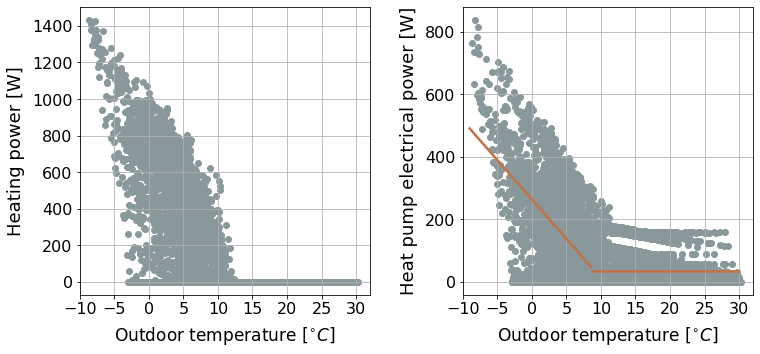

In [32]:
# Plot resulting energy signature
# Scatter plots - heat and heat pump power against outdoor temperature
T_out_range = np.arange(-9, 30,0.1)
fig, ax = plt.subplots(1,2,figsize=[11,5],
                       facecolor='w', 
                       edgecolor='w')
plt.subplots_adjust(bottom = 0.17, top = 0.97,
                    left = 0.11, right = 0.96,
                    wspace = 0.32) 
ax[0].scatter(energy_df.T_Aussen, energy_df.Q_Heizen_Kuehlen*hdu_area, 
              marker = 'o', c=colarray[0])
ax[1].scatter(energy_df.T_Aussen, energy_df.Q_hp*hdu_area, 
              marker = 'o', c=colarray[0])
ax[1].plot(T_out_range[T_out_range <= Tb], 
              coef_lin[1]+coef_lin[0]*T_out_range[T_out_range <= Tb], 
              linewidth = 2.5, c=colarray[1])
ax[1].plot(T_out_range[T_out_range >= Tb], 
              coef_const[0]*np.ones_like(T_out_range[T_out_range >= Tb]), 
              linewidth = 2.5, c=colarray[1])
ax[0].set_ylabel('Heating power [W]', fontsize=18, labelpad=7)
ax[1].set_ylabel('Heat pump electrical power [W]', fontsize=18, labelpad=7)
ax[0].xaxis.set_ticks(np.arange(-10,31,5))
ax[1].xaxis.set_ticks(np.arange(-10,31,5))
ax[0].set_xlabel('Outdoor temperature [$^{\circ}C$]', fontsize=17, labelpad = 8)
ax[1].set_xlabel('Outdoor temperature [$^{\circ}C$]', fontsize=17, labelpad = 8)
ax[0].set_xlim([-10,32])
ax[1].set_xlim([-10,32])
for k in range(2):
    ax[k].tick_params(labelsize = 16)
    # ax[k].xaxis.set_tick_params(rotation=45)
    ax[k].grid(True)